# Gaussian Shells

A modification on https://num.pyro.ai/en/latest/examples/gaussian_shells.html, a distribution we can calculate the true evidence for.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpyro
import numpyro.distributions as dist
import numpyro.infer.util

import jax
import jax.numpy as jnp
import jax.flatten_util

import optax

import matplotlib.pyplot as plt
import arviz as az

from CT_HMC_wrappers import (
    wrap_model,
    re_center_guide,
    nlogZ,
    get_value_from_index
)
from corner import corner

numpyro.set_host_device_count(4)

## Define the dist

We will use a `Mixture` to mix two of these `GaussianShell` distributions together.  As `Mixture` will re-normalize the result we will add in a factor of `2` to each shell so the result is the same has just multiplying the two base distributions.

In [3]:
class GaussainShell(dist.Distribution):
    support = dist.constraints.real_vector

    def __init__(self, loc, radius, width):
        self.loc, self.radius, self.width = loc, radius, width
        super().__init__(batch_shape=loc.shape[:-1], event_shape=loc.shape[-1:])

    def sample(self, key, sample_shape=()):
        return jnp.zeros(
            sample_shape + self.shape()
        )  # a dummy sample to initialize the samplers

    def log_prob(self, value):
        # add jnp.log(2) so it is un-normalized after mixing two of them
        normalizer =  -0.5 * jnp.log(2.0 * jnp.pi) - jnp.log(self.width) + jnp.log(2)
        d = jnp.linalg.norm(value - self.loc, axis=-1)
        return normalizer - 0.5 * ((d - self.radius) / self.width) ** 2

## Evaluate on a grid

This is simple enough we can evaluation the full distribution on a grid and use that to estimate the evidence (assuming a uniform prior over the full grid).

In [4]:
args = (
    jnp.array([0.0, -3.5]),
    jnp.array([0.0, 3.5]),
    2.0,
    0.1,
    jnp.array([-6.0, 6.0])
)

# args = (
#     jnp.array([8.5, -8.5]),
#     jnp.array([-8.5, 8.5]),
#     2.0,
#     0.1,
#     jnp.array([-11.5, 11.5])
# )

In [5]:
probs = jnp.array([0.5, 0.5])

mixing_dist = dist.Categorical(probs=probs)
D = dist.Mixture(
    mixing_dist,
    [
        GaussainShell(loc=args[0], radius=args[2], width=args[3]),
        GaussainShell(loc=args[1], radius=args[2], width=args[3]),
    ]
)

True log(Z): -1.7456541061401367


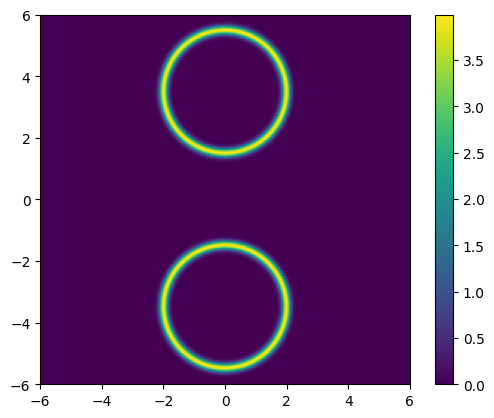

In [6]:
u_vec = jnp.linspace(args[-1][0], args[-1][1], 250)
xx, yy = jnp.meshgrid(u_vec, u_vec)

log_prob = D.log_prob(jnp.dstack((xx, yy)))

log_Z_true = (
    jax.lax.reduce(log_prob.flatten()[1:], log_prob.flatten()[0], jnp.logaddexp, (0,)) # sum pixel values
    + 2 * jnp.log(u_vec[1] - u_vec[0]) # area of one pixel
    - 2 * jnp.log(u_vec[-1] - u_vec[0]) # uniform prior
)

print(f'True log(Z): {log_Z_true}')

plt.imshow(
    jnp.exp(log_prob),
    extent=(u_vec.min(), u_vec.max(), u_vec.min(), u_vec.max()),
    origin='lower'
)
plt.colorbar();

## The model

In [7]:
def model(center1, center2, radius, width, prior_lims):
    x = numpyro.sample(
        'x',
        dist.Uniform(prior_lims[0], prior_lims[1]).expand([2]).to_event(1)
    )
    numpyro.sample(
        'shell',
        dist.Mixture(
            mixing_dist,
            [
                GaussainShell(loc=center1, radius=radius, width=width),
                GaussainShell(loc=center2, radius=radius, width=width),
            ]
        ), 
        obs=x
    )

In [8]:
rng_key = jax.random.PRNGKey(0)

## NUTS on its own

How well does standard NUTS handel this distribution?

In [9]:
nuts_key, rng_key = jax.random.split(rng_key, 2)

In [10]:
num_chains = 4

nuts_kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, dense_mass=True)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=num_chains,
    chain_method='parallel',
    progress_bar=True,
)
mcmc.run(nuts_key, *args)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x[0]  0.036  1.427  -2.039    2.029      0.027    0.019    3050.0    8765.0   
x[1] -1.734  3.389  -5.639    5.074      1.551    1.172       7.0      31.0   

      r_hat  
x[0]   1.00  
x[1]   1.53

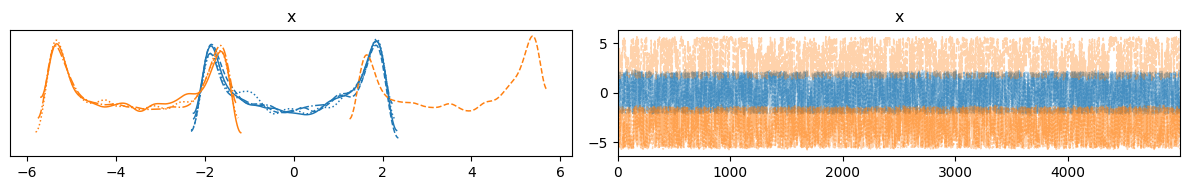

In [11]:
inf_nuts = az.from_numpyro(mcmc)

print(inf_nuts.sample_stats.diverging.data.sum(axis=1))
display(az.summary(inf_nuts))
az.plot_trace(inf_nuts)
plt.tight_layout();

We see that different chains get stuck in different modes.  Let's make a corner plot that is colored by chain to see this more clearly.

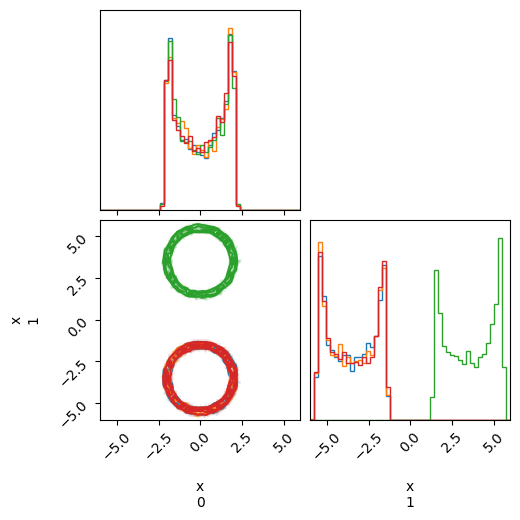

In [12]:
fig_corner = None
for i in range(num_chains):
    fig_corner = corner(
        inf_nuts.isel(chain=i),
        color=f'C{i}',
        fig=fig_corner,
        range=[args[-1], args[-1]],
        bins=50
    )

## SVI

We will do a multi-start SVI run with a `RenyiELBO` to look for a mode-covering solution.

In [13]:
svi_key, rng_key = jax.random.split(rng_key, 2)

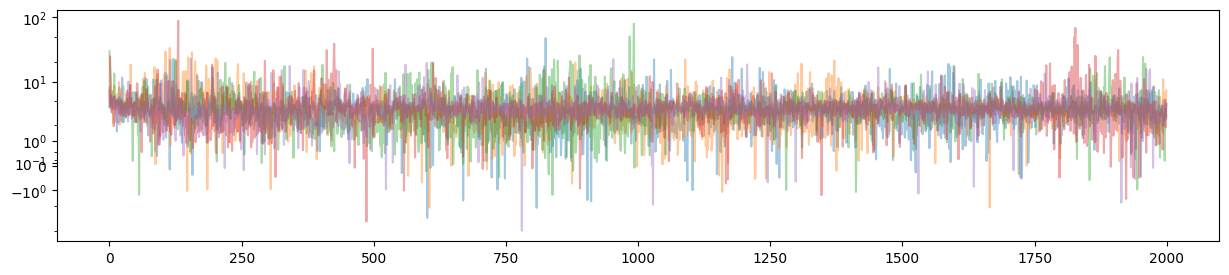

In [14]:
num_svi_runs = 5

init_fun = numpyro.infer.init_to_median()
target_guide = numpyro.infer.autoguide.AutoDiagonalNormal(model, init_loc_fn=init_fun)

scheduler1 = optax.exponential_decay(
    init_value=0.1,
    decay_rate=0.99,
    transition_steps=100
)

optim = optax.adabelief(learning_rate=scheduler1)
loss = numpyro.infer.RenyiELBO(alpha=0.1, num_particles=10)
svi = numpyro.infer.SVI(
    model,
    target_guide,
    optim,
    loss
)

@jax.vmap
def map_svi(key):
    return svi.run(
        key,
        2000,
        *args,
        progress_bar=False,
        stable_update=True
    )

svi_keys = jax.random.split(svi_key, num_svi_runs)
multi_svi_results = map_svi(svi_keys)

plt.figure(figsize=(15, 3))
plt.plot(multi_svi_results.losses.T, alpha=0.4)
plt.gca().set_yscale('asinh');

Let's draw samples from each SVI solution and treat them like chains from a sampler and make some corner plots.

In [15]:
svi_samples = target_guide.sample_posterior(rng_key, multi_svi_results.params, sample_shape=(5000,))
svi_samples_chains = jax.tree.map(lambda x: jnp.swapaxes(x, 0, 1), svi_samples)
svi_samples_chains = jax.device_get(svi_samples_chains)
multi_svi_guide_sample = az.from_dict(svi_samples_chains)

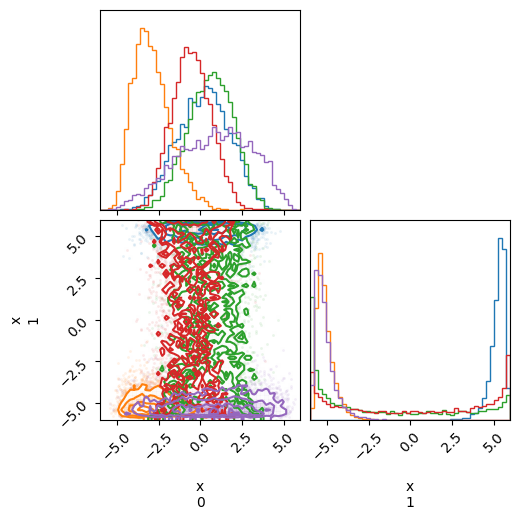

In [16]:
fig_corner = None
for i in range(num_svi_runs):
    fig_corner = corner(
        multi_svi_guide_sample.isel(chain=i),
        color=f'C{i}',
        fig=fig_corner,
        range=[args[-1], args[-1]],
        bins=50
    )

Looks like index `3` (red) is the most mode covering:

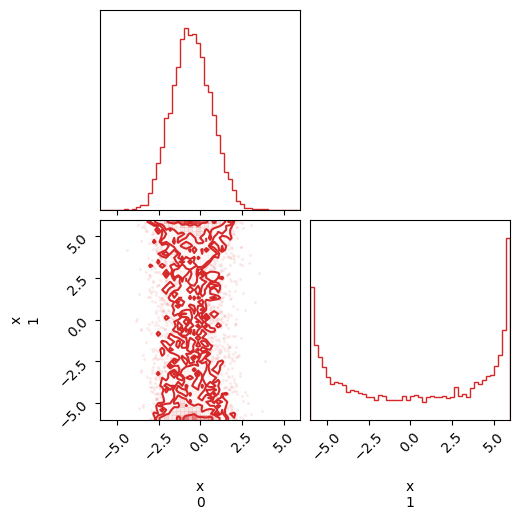

In [17]:
i=3
corner(
    multi_svi_guide_sample.isel(chain=i),
    color=f'C{i}',
    range=[args[-1], args[-1]],
    bins=50
);

## CTHMC

In [18]:
def run_inference(mcmc_key, init_key, potential_energy_fn, sample_init_fn, postprocessing_fn, svi_params):
    unconstrained_init_params = sample_init_fn(init_key, svi_params, num_chains)
    nuts_kernel = numpyro.infer.NUTS(
        potential_fn=potential_energy_fn,
        target_accept_prob=0.99,
        dense_mass=True
    )

    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_warmup=1000,
        num_samples=10000,
        num_chains=num_chains,
        chain_method='parallel',
        progress_bar=True,
        postprocess_fn=postprocessing_fn
    )
    mcmc.run(
        mcmc_key,
        init_params=unconstrained_init_params
    )
    return mcmc


def first_cthmc_run(svi_result, rng_key):
    # CTHMC seeded from an SVI result object
    mcmc_key, init_key, rng_key = jax.random.split(rng_key, 3)
    _, potential_energy_fn, sample_init_fn, postprocessing_fn, neg_elbo = wrap_model(
        model,
        args,
        {},
        target_guide,
        svi_result
    )

    cthmc = run_inference(
        mcmc_key,
        init_key,
        potential_energy_fn,
        sample_init_fn,
        postprocessing_fn,
        svi_result.params
    )
    return cthmc, neg_elbo, rng_key

In [19]:
cthmc, neg_elbo, rng_key = first_cthmc_run(
    get_value_from_index(multi_svi_results, 3), # SVI index 3 result
    rng_key
)

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[0]     -0.155  1.328  -2.037    1.992      0.016    0.011    6957.0   
x[1]      1.871  3.520  -5.309    5.670      1.173    0.858      13.0   
inv_temp  0.761  0.229   0.283    1.000      0.002    0.002   10811.0   

          ess_tail  r_hat  
x[0]       16951.0    1.0  
x[1]          53.0    1.2  
inv_temp    8614.0    1.0

Current log(Z) estimate: -1.7310738563537598
True log(Z) value: -1.7456541061401367


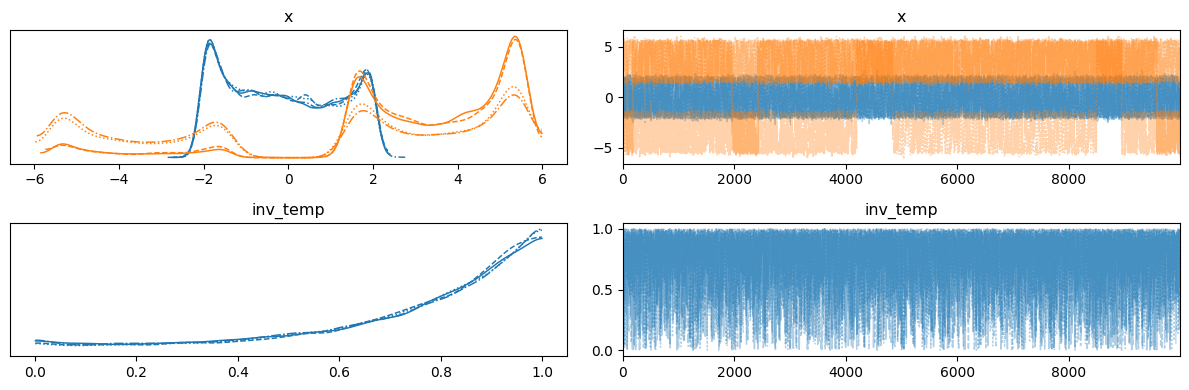

In [20]:
inf_cthmc = az.from_numpyro(cthmc)

var_names = ['x', 'inv_temp']
print(inf_cthmc.sample_stats.diverging.data.sum(axis=1))
display(az.summary(inf_cthmc, var_names=var_names))
az.plot_trace(inf_cthmc, var_names=var_names)
plt.tight_layout()

neg_log_Z = nlogZ(neg_elbo, cthmc.get_samples())
print(f'Current log(Z) estimate: {-neg_log_Z}')
print(f'True log(Z) value: {log_Z_true}')

This is much closer to converged, but the `inv_temp` is not very uniform and the `r_hat` is large for `x[1]`.  Let's look at the corner plot for each chain.

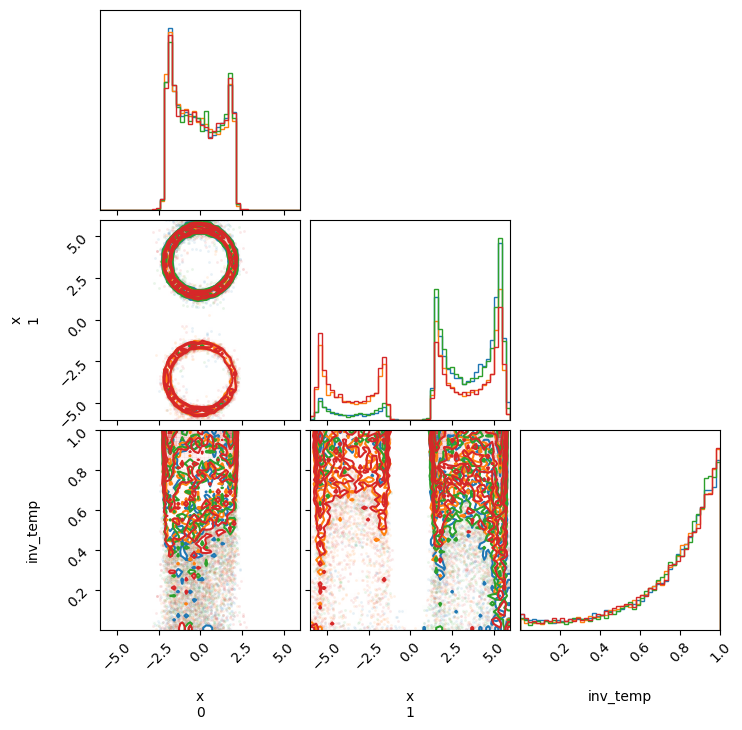

In [21]:
fig_corner = None
for i in range(num_chains):
    fig_corner = corner(
        inf_cthmc.isel(chain=i),
        color=f'C{i}',
        fig=fig_corner,
        range=[args[-1], args[-1], (0, 1)],
        bins=50,
        var_names=var_names
    )

They are for the most part identical!  Now all the chains at once.

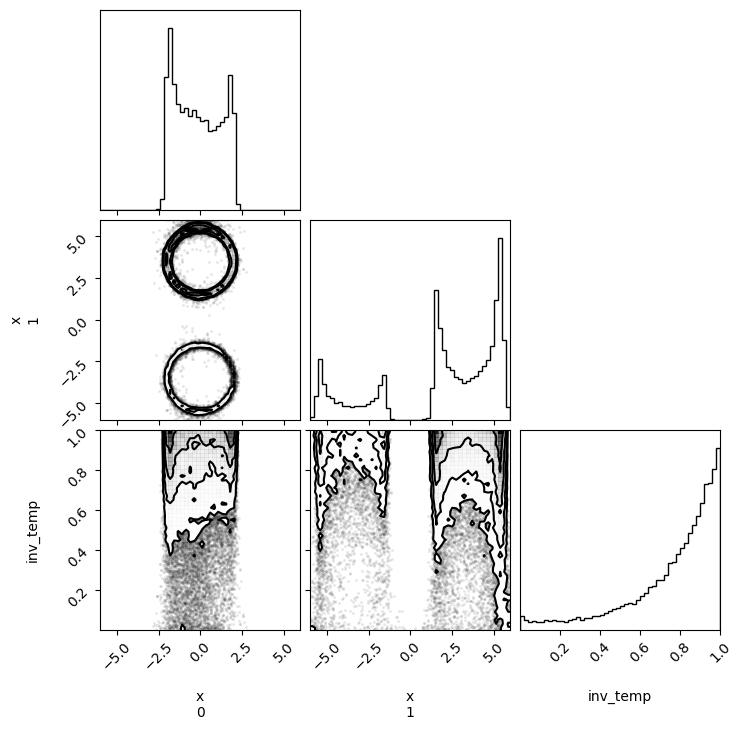

In [22]:
fig = corner(
    inf_cthmc,
    range=[args[-1], args[-1], (0, 1)],
    bins=50,
    var_names=var_names
)

## Importance sample

The corner plot looks a bit lopsided, this is because we need to use importance sampling with the weights `w1` to bring all samples into the lower temperature (`inv_temp=1`) state.  We can also weight back to the high temperature (`inv_temp=0`) state with `w0`.

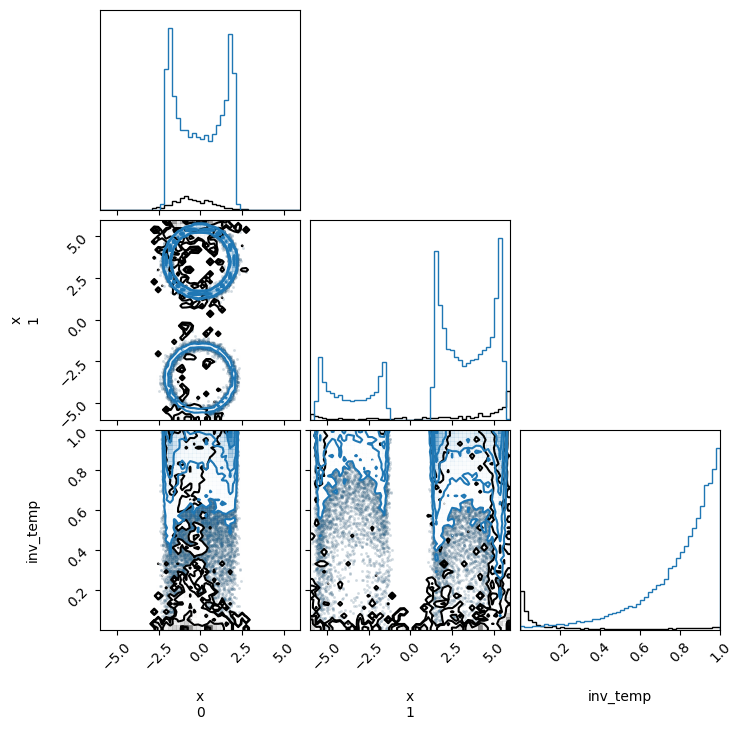

In [23]:
# flatten the weights into vectors 
w1 = inf_cthmc.posterior.w1.stack(desired=['chain', 'draw']).data
w0 = inf_cthmc.posterior.w0.stack(desired=['chain', 'draw']).data

fig = corner(
    inf_cthmc,
    range=[args[-1], args[-1], (0, 1)],
    bins=50,
    var_names=var_names,
    weights=w0,
    color='k'
)

fig = corner(
    inf_cthmc,
    range=[args[-1], args[-1], (0, 1)],
    bins=50,
    var_names=var_names,
    fig=fig,
    weights=w1,
    color='C0'
)

## Re-center and iterate

At the moment the evidence looks good, but the `inv_temp` did not have very good mixing (i.e. not close to uniform), let's try re-centring the guide on the current (weighted) samples and run the process again. 

In [24]:
print(f'Current log(Z) estimate: {-neg_log_Z}')
print(f'True log(Z) value: {log_Z_true}')

Current log(Z) estimate: -1.7310738563537598
True log(Z) value: -1.7456541061401367


As we will be running this several times, let's wrap the iteration and standard plots into some functions.

In [25]:
def iterate_cthmc(cthmc, neg_elbo, rng_key):
    iter_param, iter_neg_elbo = re_center_guide(
        model,
        args,
        {},
        cthmc,
        target_guide,
        neg_elbo
    )
    mcmc_key, init_key, rng_key = jax.random.split(rng_key, 3)
    _, potential_energy_fn, sample_init_fn, postprocessing_fn, neg_elbo = wrap_model(
        model,
        args,
        {},
        target_guide,
        neg_elbo=iter_neg_elbo,
        guide_params=iter_param
    )
    cthmc = run_inference(
        mcmc_key,
        init_key,
        potential_energy_fn,
        sample_init_fn,
        postprocessing_fn,
        iter_param
    )
    return cthmc, neg_elbo, rng_key


def standard_plots(cthmc):
    inf_cthmc = az.from_numpyro(cthmc)

    var_names = ['x', 'inv_temp']
    print(inf_cthmc.sample_stats.diverging.data.sum(axis=1))
    display(az.summary(inf_cthmc, var_names=var_names))
    az.plot_trace(inf_cthmc, var_names=var_names)
    plt.tight_layout()

    neg_log_Z = nlogZ(neg_elbo, cthmc.get_samples())
    print(f'Current log(Z) estimate: {-neg_log_Z}')
    print(f'True log(Z) value: {log_Z_true}')

    w1 = inf_cthmc.posterior.w1.stack(desired=['chain', 'draw']).data
    w0 = inf_cthmc.posterior.w0.stack(desired=['chain', 'draw']).data

    fig = corner(
        inf_cthmc,
        range=[args[-1], args[-1], (0, 1)],
        bins=50,
        var_names=var_names,
        weights=w0,
        color='k'
    )

    fig = corner(
        inf_cthmc,
        range=[args[-1], args[-1], (0, 1)],
        bins=50,
        var_names=var_names,
        fig=fig,
        weights=w1,
        color='C0'
    )
    return inf_cthmc

Iterate the process once.

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[0]     -0.005  1.352  -2.039    2.034      0.017    0.012    6450.0   
x[1]      0.133  3.818  -5.425    5.561      0.292    0.207     225.0   
inv_temp  0.580  0.304   0.049    1.000      0.004    0.003    6460.0   

          ess_tail  r_hat  
x[0]       19049.0   1.00  
x[1]        3215.0   1.02  
inv_temp   10772.0   1.00

Current log(Z) estimate: -1.7452430725097656
True log(Z) value: -1.7456541061401367


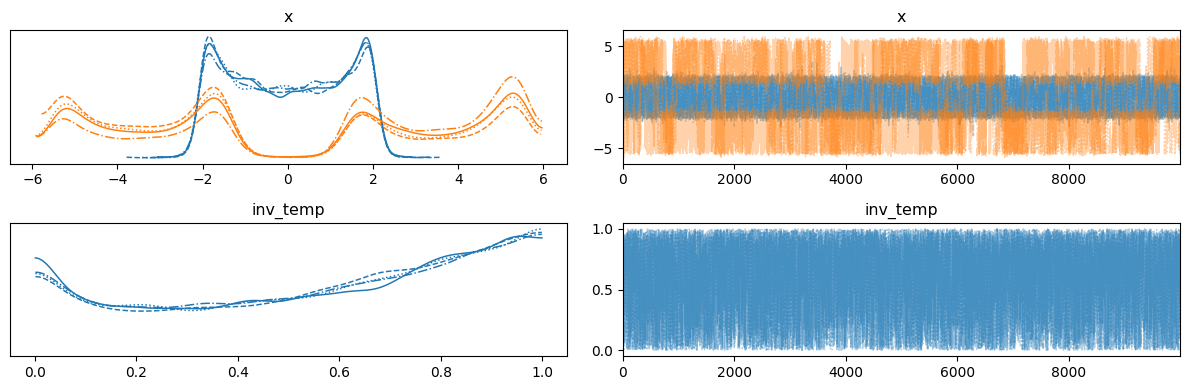

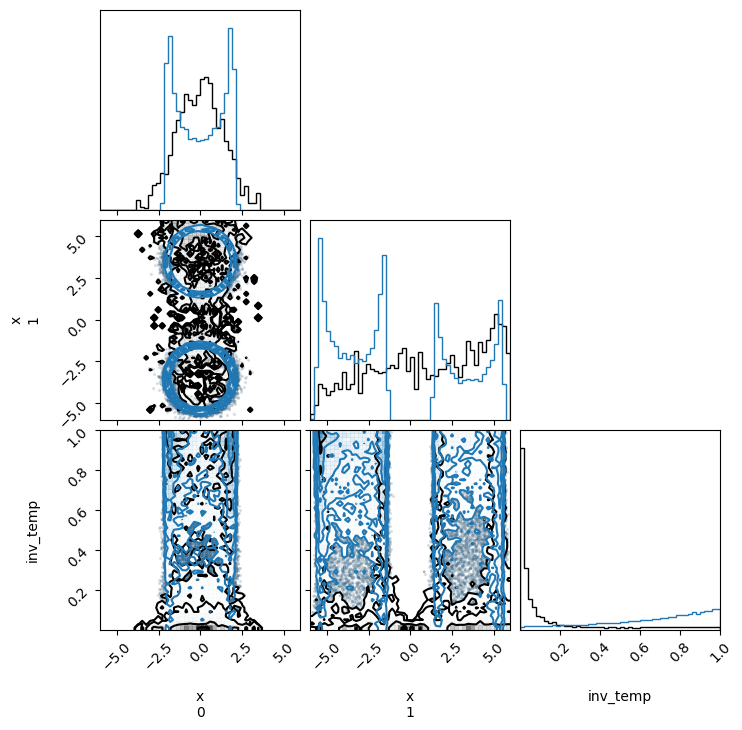

In [26]:
cthmc, neg_elbo, rng_key = iterate_cthmc(cthmc, neg_elbo, rng_key)
inf_cthmc = standard_plots(cthmc)

A far more even distribution in `inv_temp` and quite accurate evidence!  Looking at the corner plot, the two rings are a bit unbalanced, let's run one more iteration to see if it helps.

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[0]      0.003  1.355  -2.035    2.042      0.018    0.013    5958.0   
x[1]     -0.302  3.832  -5.544    5.463      0.312    0.221     207.0   
inv_temp  0.582  0.302   0.052    1.000      0.003    0.002    8799.0   

          ess_tail  r_hat  
x[0]       18654.0   1.00  
x[1]        2884.0   1.01  
inv_temp   10637.0   1.00

Current log(Z) estimate: -1.7390050888061523
True log(Z) value: -1.7456541061401367


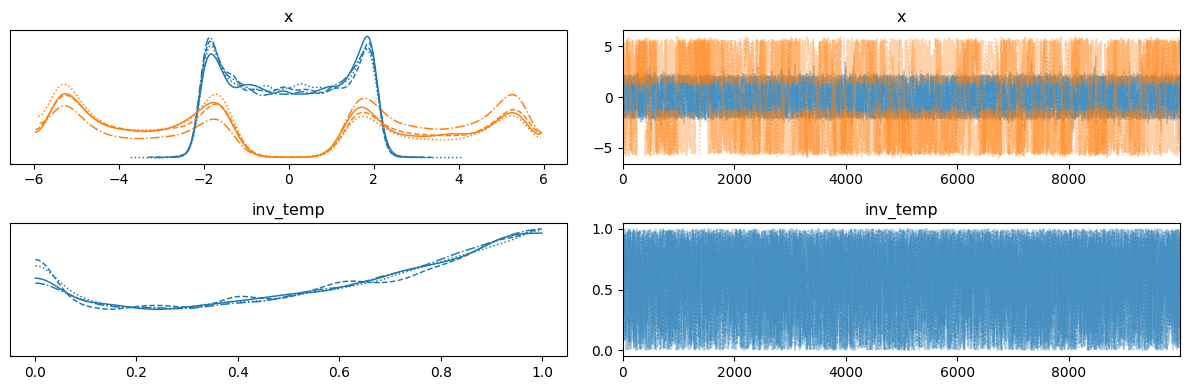

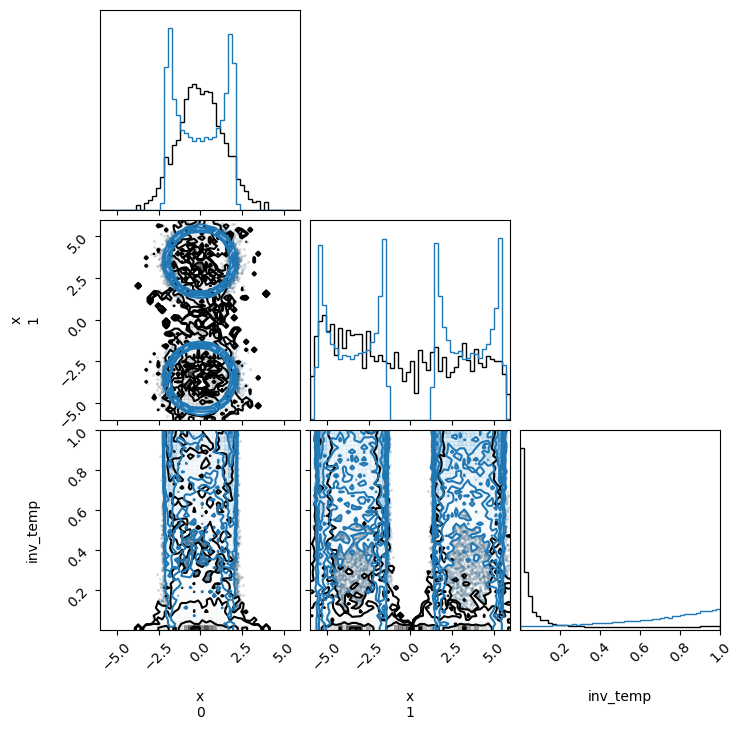

In [27]:
cthmc, neg_elbo, rng_key = iterate_cthmc(cthmc, neg_elbo, rng_key)
inf_cthmc = standard_plots(cthmc)

Much better!

## What if the guide is not that great

Before we picked the most evenly spread of the 5 SVI solutions from the start.  But what if we picked one of the worst ones instead?

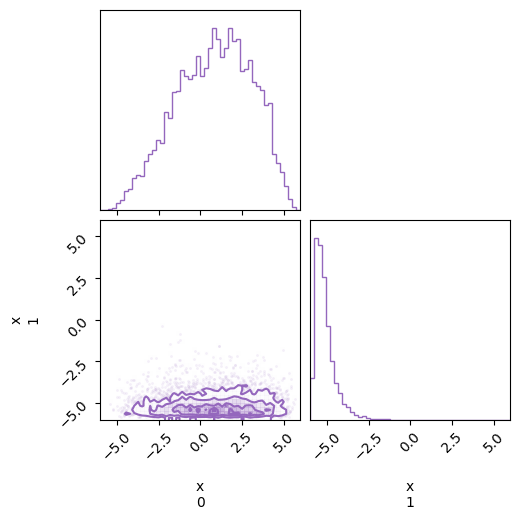

In [28]:
i=4
corner(
    multi_svi_guide_sample.isel(chain=i),
    color=f'C{i}',
    range=[args[-1], args[-1]],
    bins=50
);

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[0]      0.048  1.354  -2.013    2.045      0.018    0.013    6032.0   
x[1]     -4.213  1.321  -5.645   -1.577      0.016    0.011    7346.0   
inv_temp  0.717  0.262   0.166    1.000      0.003    0.002   10975.0   

          ess_tail  r_hat  
x[0]       17175.0    1.0  
x[1]       16213.0    1.0  
inv_temp   11037.0    1.0

Current log(Z) estimate: -2.249417781829834
True log(Z) value: -1.7456541061401367


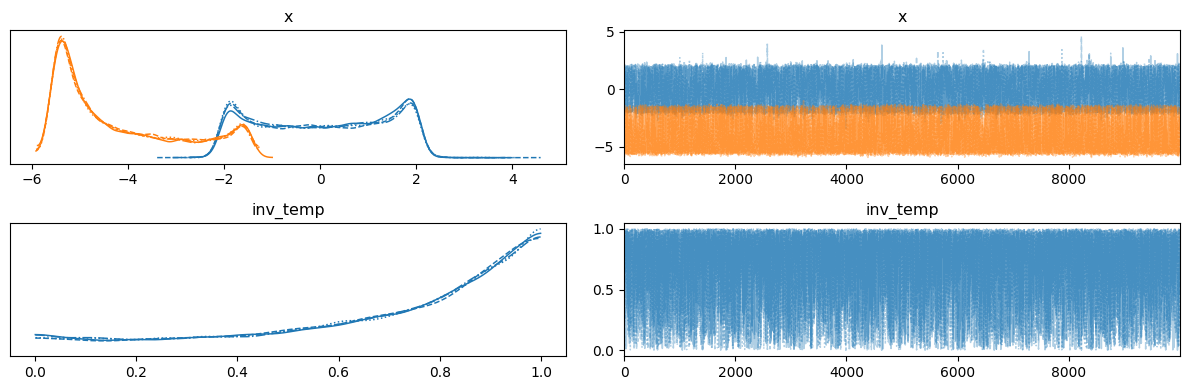

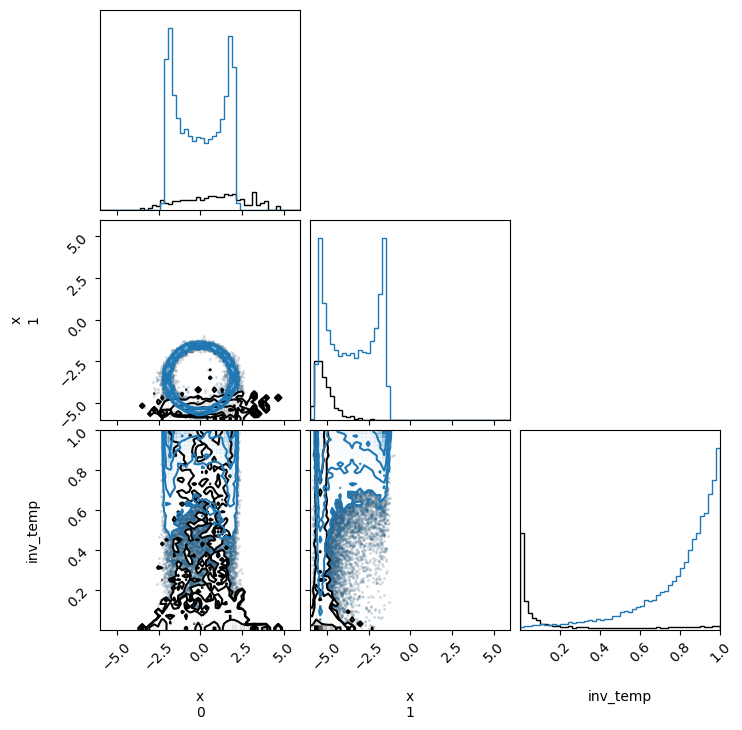

In [29]:
cthmc, neg_elbo, rng_key = first_cthmc_run(
    get_value_from_index(multi_svi_results, 4),
    rng_key
)
inf_cthmc = standard_plots(cthmc)

Not that great, we can see only one mode was found.  Let's iterate this solution and see what happens.

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[0]      0.011  1.394  -2.039    2.056      0.017    0.012    7117.0   
x[1]     -2.934  2.600  -5.744    2.641      0.325    0.231     120.0   
inv_temp  0.590  0.307   0.052    1.000      0.010    0.008     789.0   

          ess_tail  r_hat  
x[0]       21131.0   1.00  
x[1]         118.0   1.03  
inv_temp    7560.0   1.01

Current log(Z) estimate: -2.020893096923828
True log(Z) value: -1.7456541061401367


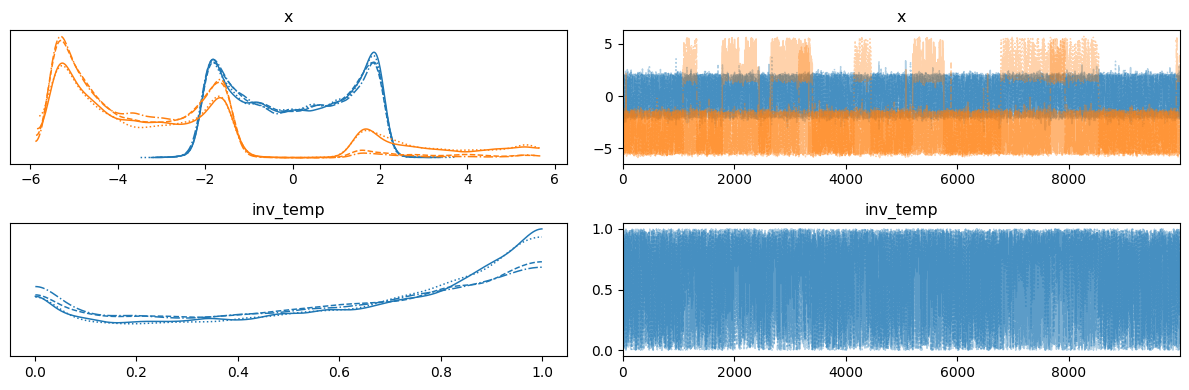

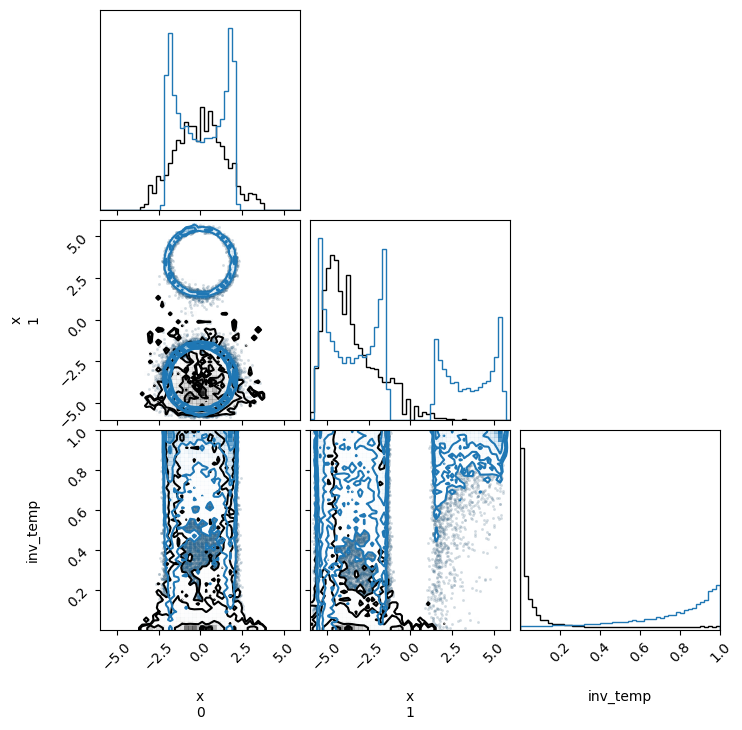

In [30]:
cthmc, neg_elbo, rng_key = iterate_cthmc(cthmc, neg_elbo, rng_key)
inf_cthmc = standard_plots(cthmc)

For this distribution the one mode is close enough to the other that the re-centered guide has helped the sampler find it.  Although the importance weights are doing quite a bit of heavy lifting at the end.  And now one more iteration to try and clean it up.

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[0]     -0.004  1.344  -2.024    2.044      0.017    0.012    6934.0   
x[1]     -0.653  3.798  -5.567    5.432      0.284    0.201     236.0   
inv_temp  0.601  0.300   0.060    1.000      0.003    0.002    8810.0   

          ess_tail  r_hat  
x[0]       19955.0   1.00  
x[1]        2520.0   1.01  
inv_temp    9811.0   1.00

Current log(Z) estimate: -1.8104782104492188
True log(Z) value: -1.7456541061401367


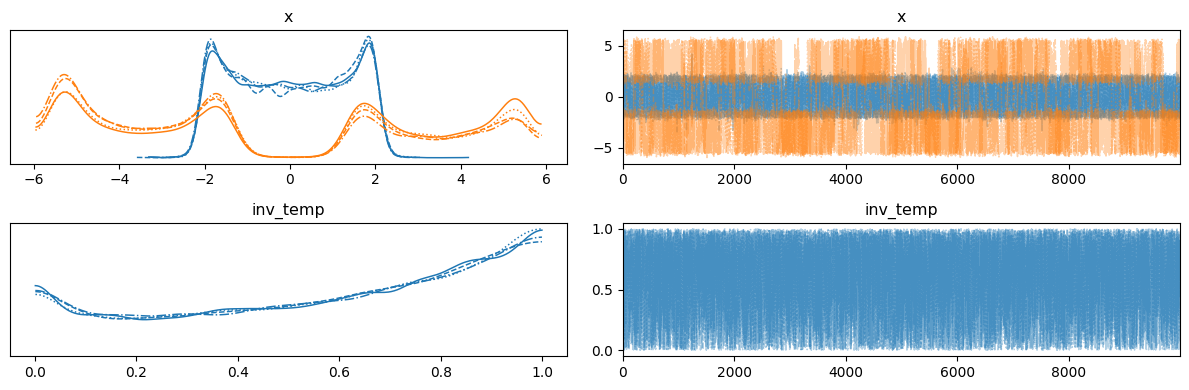

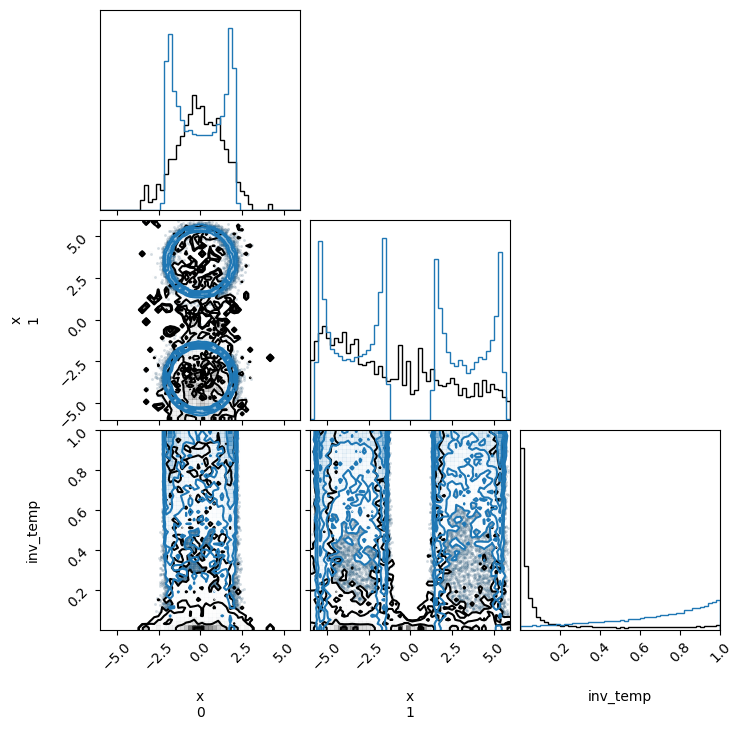

In [31]:
cthmc, neg_elbo, rng_key = iterate_cthmc(cthmc, neg_elbo, rng_key)
inf_cthmc = standard_plots(cthmc)

It took three iterations, but we were able to find a well mixed solution again!

Note: if the second mode were further away I any amount of iterations would help (try running the notebook with the commented out `args` and see).  This method is dependent on a mode covering SVI solution.  Would be interesting to see what using the prior as the first guide would do (and using an auto-diag-normal re-centering from that point on).